In [1]:
# import result data
import os
import csv

RESULT_PATH = 'results/26-05-2023_02hh_41mm/'
AWS_IP_RANGES_PATH = '/Users/abdullah/Documents/PrimeVideo/PrimeVideo Scripts/aws-ip-ranges.json'

myimage_csv = "results/26-05-2023_02hh_41mm/myimage_26-05-2023_02hh_41mm.csv"
ringsofpower_vid_csv = "results/26-05-2023_02hh_41mm/ringsofpower_vid_26-05-2023_02hh_41mm.csv"
ringsofpower_aud_csv = "results/26-05-2023_02hh_41mm/ringsofpower_aud_26-05-2023_02hh_41mm.csv"
harlem_csv = "results/26-05-2023_02hh_41mm/harlem_26-05-2023_02hh_41mm.csv"
samaritan_csv = "results/26-05-2023_02hh_41mm/samaritan_26-05-2023_02hh_41mm.csv"


def read_column_from_csv(file_path, column_name):
    column_values = []
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            column_values.append(row[column_name])
    return column_values

def read_columns_from_multiple_csv_files(directory_path, column_name):
    all_column_values = {}
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory_path, file_name)
            column_values = read_column_from_csv(file_path, column_name)
            all_column_values[file_name] = column_values
    return all_column_values

def get_all_column_values(column_name):
    directory_path = RESULT_PATH
    #column_name = 'latency(ms)'
    all_column_values = read_columns_from_multiple_csv_files(directory_path, column_name)
    #print(all_column_values)
    for i, column_values in all_column_values.items():
        pass
        #print(f'"{i}"')
        #print(i, column_values[:5])
    return all_column_values


In [2]:
### Functions to map IP to AWS related data

import json
import ipaddress

# reads AWS ip ranges from json publicly avaialble
def get_aws_ip_ranges():
    # Open the JSON file
    with open(AWS_IP_RANGES_PATH, 'r') as file:
        # Load the JSON data into a dictionary
        data = json.load(file)
        return data["prefixes"]

def map_ip_to_aws(ip_address, ranges_data_list):
    matching_aws_data = None
    
    try:
        ip = ipaddress.ip_address(ip_address)
    except Exception as e:
        print(ip_address, e)
        return matching_aws_data
    
    longest_prefix = -1
    matching_service = ""
    for range_data in ranges_data_list:
        subnet = range_data["ip_prefix"]
        network = ipaddress.ip_network(subnet)
        service = range_data["service"]
        region = range_data["region"]
        if ip in network and network.prefixlen >= longest_prefix:
            if service == "AMAZON" and matching_service != "AMAZON" and matching_service != "":
                continue
            matching_aws_data = range_data
            matching_service = service
            longest_prefix = network.prefixlen

    return matching_aws_data


# for testing
#responseIP = "18.165.185.120"
responseIP = "18.165.185.129"
subnet_list = get_aws_ip_ranges()
aws_data = map_ip_to_aws(responseIP, subnet_list)
print(responseIP,"\n",aws_data)

18.165.185.129 
 {'ip_prefix': '18.164.0.0/15', 'region': 'GLOBAL', 'service': 'CLOUDFRONT', 'network_border_group': 'GLOBAL'}


In [3]:
### Add AWS Service info in the CSV files

import pandas as pd

ip_to_aws = {} # storing to avoid longest prefix match call to function

# Reads a column containing IPs from a csv and maps the IPs to AWS data
def get_ip_to_aws_data(dataname, ip_column, csv_filename):
    file_path = f"{RESULT_PATH}/{csv_filename}"
    ips = read_column_from_csv(file_path, ip_column)
    ranges_list = get_aws_ip_ranges()

    service_list = []
    
    for ip in ips:
        if ip in ip_to_aws:
            aws_data = ip_to_aws[ip]
        else:
            aws_data = map_ip_to_aws(ip, ranges_list)
        
        if aws_data:
            aws_service = aws_data[dataname]
        else:
            aws_service = ""
        
        service_list.append(aws_service)
        ip_to_aws[ip] = aws_data
        print(ip, aws_service, dataname, csv_filename)
        #break
    
    return service_list

# Adds AWS related info for the resonseIP and X-Server-IP in the CSV file
def add_aws_data(csv_filename):
    resp_ip_service = get_ip_to_aws_data("service", "responseIP", csv_filename)
    resp_ip_region = get_ip_to_aws_data("region", "responseIP", csv_filename)
    X_Server_IP_service = get_ip_to_aws_data("service", "X-Server-IP", csv_filename)
    X_Server_IP_region = get_ip_to_aws_data("region", "X-Server-IP", csv_filename)

    # Read the CSV file
    df = pd.read_csv(f'{RESULT_PATH}/{csv_filename}')

    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 1
    # Insert the new column at the specified position with data
    if 'responseIP_service' not in df.columns:
        df.insert(insert_position, 'responseIP_service', resp_ip_service)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("responseIP") + 2
    # Insert the new column at the specified position with data
    if 'responseIP_region' not in df.columns:
        df.insert(insert_position, 'responseIP_region', resp_ip_region)

    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 1
    # Insert the new column at the specified position with data
    if 'X-Server-IP_service' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_service', X_Server_IP_service)
    
    # Define the position to insert the new column
    insert_position = df.columns.get_loc("X-Server-IP") + 2
    # Insert the new column at the specified position with data
    if 'X-Server-IP_region' not in df.columns:
        df.insert(insert_position, 'X-Server-IP_region', X_Server_IP_region)

    # Save the modified data back to the CSV file
    df.to_csv(f'{RESULT_PATH}/{csv_filename}', index=False)

# go through all csv result file and add in the aws service info
for file_name in os.listdir(RESULT_PATH):
    if file_name.endswith('.csv'):
        print(file_name)
        add_aws_data(file_name)
        '''
        # for testing, only add aws info in this file
        if "samaritan" in file_name:
            add_aws_data(file_name)
        '''

samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-0

46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29 

46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  service samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29 

178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50 

46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan

46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan

178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50 

178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50 

178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  service samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50 

46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan

46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan_26-05-2023_02hh_41mm.csv
46.228.150.29  region samaritan

178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan_26-05-2023_02hh_41mm.csv
178.79.237.50  region samaritan

18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.81 CLOUDFRONT 

18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT 

18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT service ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.161.111.71 CLOUDFRONT 

18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.124 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165

18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.115 G

18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_aud_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL

   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41

   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41

   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41mm.csv
   service ringsofpower_aud_26-05-2023_02hh_41

   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ri

   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ri

   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
   region ringsofpower_aud_26-05-2023_02hh_41mm.csv
ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.124 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.124 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.124 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18

18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 CLOUD

18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT service ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 CLOUDFRONT 

18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.71 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.115 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.11

18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.161.111.53 GLOBAL

18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL region ringsofpower_vid_26-05-2023_02hh_41mm.csv
18.165.183.22 GLOBAL

   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41

   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41

   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41mm.csv
   service ringsofpower_vid_26-05-2023_02hh_41

   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ri

   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ri

   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ringsofpower_vid_26-05-2023_02hh_41mm.csv
   region ri

myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.68 CLOUDFRONT service myimage_26-05-2023_02hh_4

18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.66.212.34 CLOUDFRONT s

18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.161 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.161.94.

18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm.csv
18.165.185.120 CLOUDFRONT service myimage_26-05-2023_02hh_41mm

18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.185.128 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.165.1

18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05-2023_02hh_41mm.csv
18.161.94.90 GLOBAL region myimage_26-05

   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02

   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02

   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02hh_41mm.csv
   service myimage_26-05-2023_02

   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region m

   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region m

   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region myimage_26-05-2023_02hh_41mm.csv
   region m

54.182.219.101 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.120 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.116 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.119 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.101 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.120 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.116 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.101 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.120 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.116 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.101 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220

54.182.219.102 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.103 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.103 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.111 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.108 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.112 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.116 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.104 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.108 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.112 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.109 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.108 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.112 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130

54.240.131.121 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.100 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.110 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.121 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.119 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.100 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.100 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.110 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.121 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.119 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.100 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.100 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.110 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131

54.182.219.106 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.112 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.114 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.109 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.110 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.106 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.112 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.102 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.110 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.106 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.112 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.114 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.109 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.102 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.110 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218

54.240.129.103 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.108 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.108 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.107 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.108 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.117 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.131.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.107 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129.103 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.130.115 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.240.129

54.182.218.99 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.109 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.99 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.104 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.109 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.218.99 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.219.113 CLOUDFRONT service harlem_26-05-2023_02hh_41mm.csv
54.182.220.10

54.182.219.104 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.101 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.103 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.104 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.111 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.114 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.110 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.101 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.103 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.104 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.111 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.114 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.110 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.101 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.104 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.104 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.111 GLOBAL re

54.182.220.105 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.105 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.101 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.112 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.100 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.105 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.105 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.105 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.101 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.112 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.105 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.101 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.219.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.218.112 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.220.105 GLOBAL re

54.240.129.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.130.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.131.102 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.110 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.130.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.131.102 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.110 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.130.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.131.102 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.110 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.130.116 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.131.102 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.110 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.240.129.116 GLOBAL re

54.182.180.41 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.166 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.166 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.42 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.173 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.166 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.18 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.9 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.165 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.49 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.8 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.209 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.175 CLOUDFRONT_ORIGIN_FACING service 

54.182.181.211 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.180.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.14 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.203 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.180.14 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.196 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.233 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.212.196 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.213.48 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.231 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.210.200 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.197 CLOUDFRONT_ORIGIN_FACING servi

54.182.185.206 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.166 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.19 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.163 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.47 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.48 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.3 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.200 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.11 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.164 CLOUDFRONT_ORIGIN_FACING service h

54.182.183.201 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.180.6 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.176 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.36 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.178 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.40 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.9 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.167 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.198 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.202 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.202 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.167 CLOUDFRONT_ORIGIN_FACING service

54.239.210.232 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.212.203 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.213.80 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.215.82 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.81 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.213.40 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.212.232 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.215.49 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.47 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.212.209 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.213.43 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.233 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.45 CLOUDFRONT_ORIGIN_FACING service 

54.182.180.4 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.13 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.199 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.171 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.174 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.200 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.45 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.48 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.173 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.47 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.202 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.10 CLOUDFRONT_ORIGIN_FACING service 

54.239.213.37 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.72 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.198 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.234 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.212.236 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.72 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.215.80 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.214.234 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.213.48 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.80 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.212.239 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.211.39 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.239.210.200 CLOUDFRONT_ORIGIN_FACING service

54.182.184.12 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.164 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.184.5 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.170 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.210 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.182.36 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.196 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.167 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.174 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.183.165 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.181.198 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.185.176 CLOUDFRONT_ORIGIN_FACING service harlem_26-05-2023_02hh_41mm.csv
54.182.180.49 CLOUDFRONT_ORIGIN_FACING servi

54.182.182.37 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.181.165 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.182.18 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.180.6 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.180.11 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.184.15 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.185.208 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.183.170 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.181.202 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.185.201 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.185.176 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.183.167 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.181.201 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.185.201 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.184.36 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.183.205 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.182.180.11 GLOBAL region har

54.239.212.196 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.210.207 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.213.81 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.214.207 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.215.41 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.214.197 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.210.231 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.212.201 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.214.209 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.210.202 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.211.49 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.212.196 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.214.239 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.214.197 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.214.197 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.210.203 GLOBAL region harlem_26-05-2023_02hh_41mm.csv
54.239.213.36 GLOBAL region

*** Avg latency ***
samaritan : 14.35 ms ,   90% CI:  [14.24, 14.46]
ringsofpower_aud : 11.8 ms ,   90% CI:  [11.62, 11.98]
ringsofpower_vid : 11.03 ms ,   90% CI:  [10.88, 11.18]
myimage : 13.97 ms ,   90% CI:  [13.77, 14.17]
harlem : 62.05 ms ,   90% CI:  [58.91, 65.19]


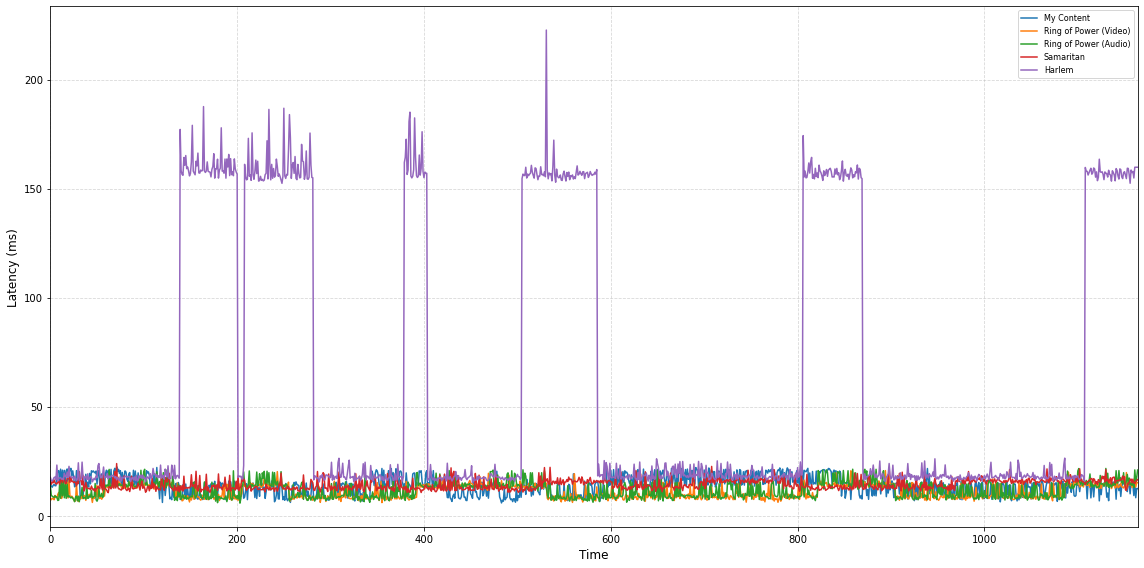

In [4]:
### LATENCY PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("latency(ms)")
all_column_values = {}
print("*** Avg latency ***")
for i, column_values in all_column_values_raw.items():
    column_values_float = [round(float(value),2) for value in column_values]
    all_column_values[i] = column_values_float
    mean = round(np.mean(column_values_float),2)
    confidence_interval = [round(val, 2) for val in stats.t.interval(0.90, len(column_values_float) - 1, loc=mean, scale=stats.sem(column_values_float))]
    print(i.split("_26")[0],":", mean, "ms , ", " 90% CI: ",confidence_interval)

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
ax.plot(time[:len(myimage)], myimage, label='My Content')
ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
ax.plot(time[:len(harlem)], harlem, label='Harlem')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Latency (ms)', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()


*** Hop Counts ***
samaritan : 10.04  90% CI:  [9.97, 10.11]
ringsofpower_aud : 16.77  90% CI:  [16.74, 16.8]
ringsofpower_vid : 16.77  90% CI:  [16.74, 16.8]
myimage : 17.31  90% CI:  [17.24, 17.38]
harlem : 22.49  90% CI:  [22.31, 22.67]


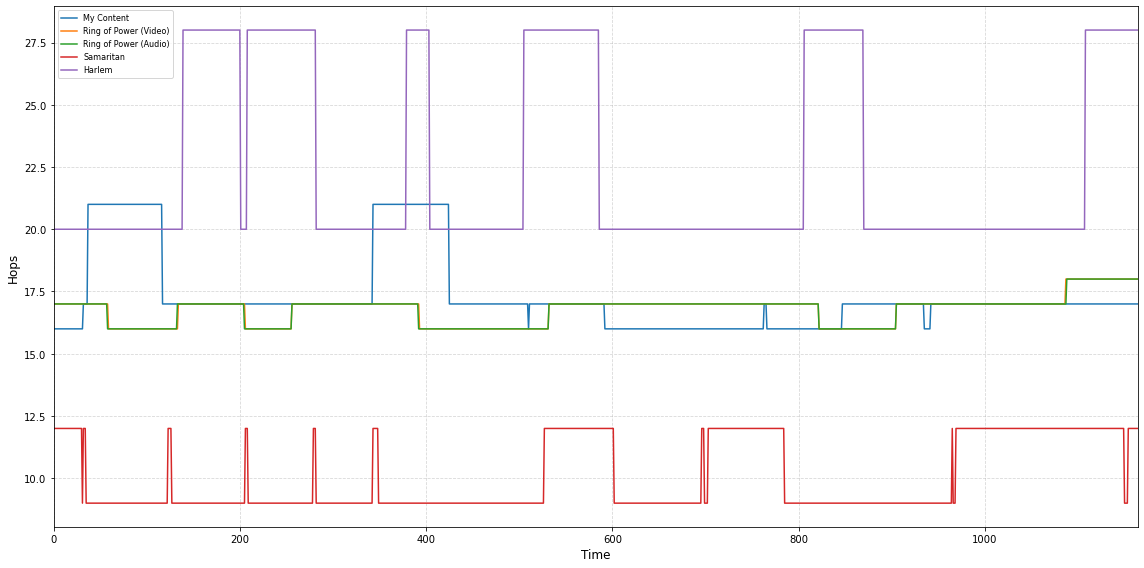

In [5]:
### HOPCOUNT PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values_raw = get_all_column_values("hop count")
all_column_values = {}
print("*** Hop Counts ***")
for i, column_values in all_column_values_raw.items():
    column_values_float = [int(value) for value in column_values]
    all_column_values[i] = column_values_float
    mean = round(np.mean(column_values_float),2)
    confidence_interval = [round(val, 2) for val in stats.t.interval(0.90, len(column_values_float) - 1, loc=mean, scale=stats.sem(column_values_float))]
    print(i.split("_26")[0],":", mean, " 90% CI: ",confidence_interval)

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
ax.plot(time[:len(myimage)], myimage, label='My Content')
ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
ax.plot(time[:len(harlem)], harlem, label='Harlem')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()


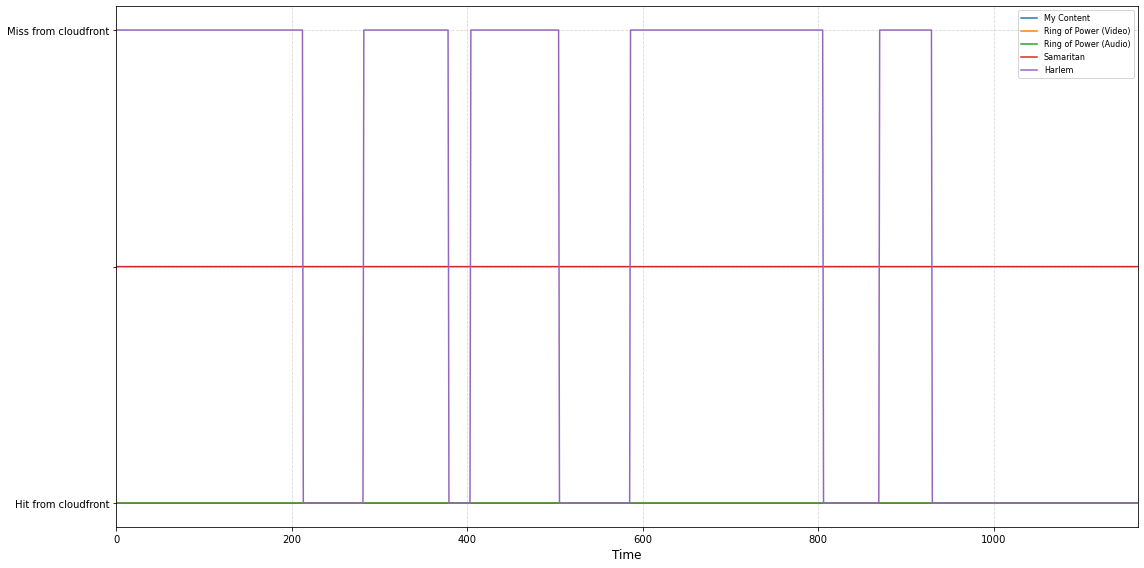

In [8]:
### X-Cache Hit PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Cache")

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
ax.plot(time[:len(myimage)], myimage, label='My Content')
ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
ax.plot(time[:len(harlem)], harlem, label='Harlem')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

In [9]:
import geoip2.database
import json
 

def ip_to_location(ip_address):
    # Load the GeoIP2 database
    reader = geoip2.database.Reader('GeoLite2-City.mmdb')
    
    try:
        # Perform the IP lookup
        response = reader.city(ip_address)

        # Get the city name
        city_name = response.city.name
        country_name = response.country.name
    
    except Exception as e:
        city_name, country_name = "", ""

    # Close the GeoIP2 reader
    reader.close()
    return [city_name, country_name]


def iata_to_location(iata_code):
    iata_code = iata_code[:3]
    # Open the JSON file
    with open('/Users/abdullah/Documents/PrimeVideo/PrimeVideo Scripts/cloudfront-edge-locations.json', 'r') as file:
        # Load the JSON data into a dictionary
        data = json.load(file)
    
    iata_to_location = {}
    for iata, info in data["nodes"].items():
        country = info["country"]
        city = info["city"]
        airport = info["airport"]
        iata_to_location[iata] = [city, country, airport]
        #print(iata, city)
    
    if iata_code in iata_to_location:
        return iata_to_location[iata_code]
    else:
        return ["","",""]


if __name__ == '__main__':
    # testing
    ip_address = '46.228.150.29'
    location = ip_to_location(ip_address)
    print(f"{ip_address} is mapped to {location}")

    iata_code = "BNE50-P2"
    location = iata_to_location(iata_code)
    print(f"{iata_code} is mapped to {location[:2]}") # print only city and country

46.228.150.29 is mapped to ['Milan', 'Italy']
BNE50-P2 is mapped to ['Brisbane', 'Australia']


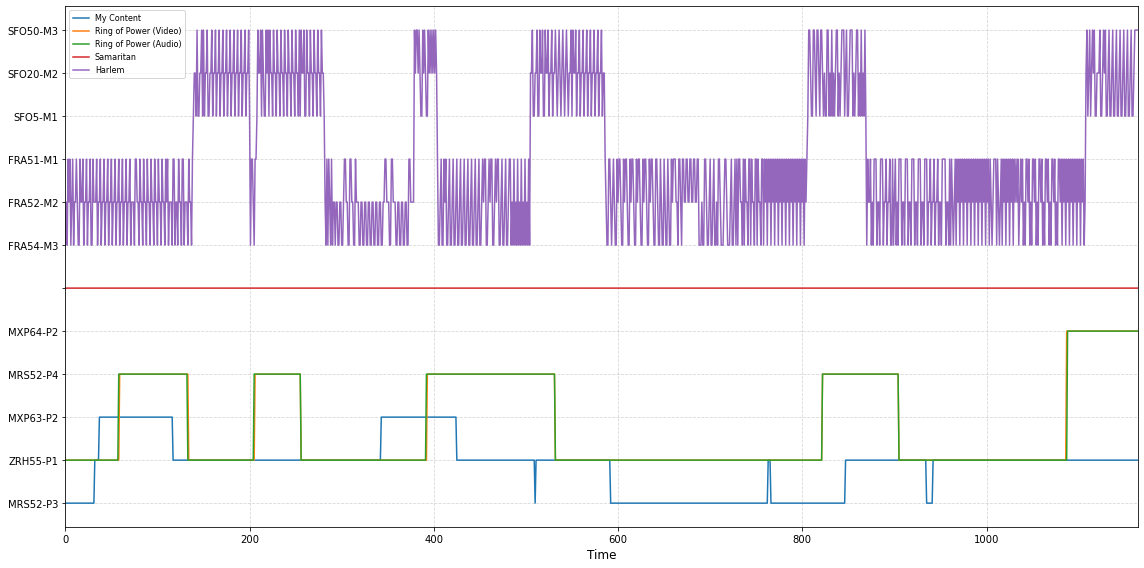

MRS52-P3 = Marseille France
ZRH55-P1 = Zürich Switzerland
SFO20-M2 = San Francisco, CA United States
FRA52-M2 = Frankfurt Germany
FRA51-M1 = Frankfurt Germany
MRS52-P4 = Marseille France
MXP64-P2 = Milan Italy
SFO5-M1 = San Francisco, CA United States
MXP63-P2 = Milan Italy
SFO50-M3 = San Francisco, CA United States
FRA54-M3 = Frankfurt Germany


In [10]:
### CloudFront Edge Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
ax.plot(time[:len(myimage)], myimage, label='My Content')
ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
ax.plot(time[:len(harlem)], harlem, label='Harlem')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()


all_codes = set(myimage + ringsofpower_vid + ringsofpower_aud + samaritan + harlem)
for code in all_codes:
    if len(code)>3:
        location = iata_to_location(code)
        print(code,"=", location[0], location[1])

# format = IATACode<DatacenterCode>-Cluster<ClusterNumber> (I assumed)
# e.g, ZRH55-P1
# It is not possible to determine the exact meaning without access to Amazon's internal documentation.

In [11]:
### CloudFront Edge Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Amz-Cf-Pop")

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

from collections import Counter

def calculate_percentage_distribution(lst):
    counter = Counter(lst)
    total_count = len(lst)
    distribution = {}

    for value, count in counter.items():
        percentage = (count / total_count) * 100
        distribution[value] = round(percentage,2)

    sorted_distribution = dict(sorted(distribution.items(), key=lambda x: x[1], reverse=True))
    return sorted_distribution

print("***** Distribution *****\n")

print("My Content:")
distribution = calculate_percentage_distribution(myimage)
for value, percentage in distribution.items():
    print(f"{value}: {percentage}%")

print("\nRings of Power:")
distribution = calculate_percentage_distribution(ringsofpower_vid)
for value, percentage in distribution.items():
    print(f"{value}: {percentage}%")

print("\nHarlem:")
distribution = calculate_percentage_distribution(harlem)
for value, percentage in distribution.items():
    print(f"{value}: {percentage}%")

***** Distribution *****

My Content:
ZRH55-P1: 61.03%
MRS52-P3: 25.06%
MXP63-P2: 13.91%

Rings of Power:
ZRH55-P1: 63.52%
MRS52-P4: 29.79%
MXP64-P2: 6.7%

Harlem:
FRA51-M1: 23.86%
FRA52-M2: 23.09%
FRA54-M3: 21.89%
SFO20-M2: 12.19%
SFO5-M1: 9.53%
SFO50-M3: 9.44%


['Marseille', 'Marseille', 'Marseille', 'Marseille', 'Marseille']


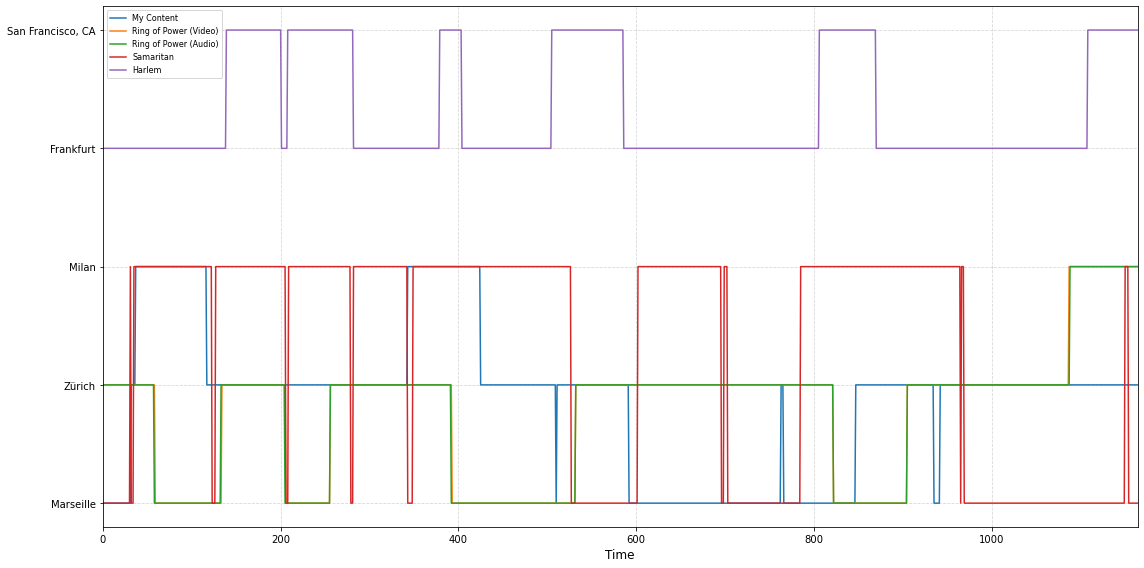

In [12]:
### Geographical Locations PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("X-Server-IP")

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

samaritan = [ip_to_location(ip_address)[0] for ip_address in samaritan]
print(samaritan[:5])


all_column_values = get_all_column_values("X-Amz-Cf-Pop")
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

myimage = [iata_to_location(iata)[0] for iata in myimage]
ringsofpower_vid = [iata_to_location(iata)[0] for iata in ringsofpower_vid]
ringsofpower_aud = [iata_to_location(iata)[0] for iata in ringsofpower_aud]
harlem = [iata_to_location(iata)[0] for iata in harlem]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
ax.plot(time[:len(myimage)], myimage, label='My Content')
ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
ax.plot(time[:len(harlem)], harlem, label='Harlem')

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

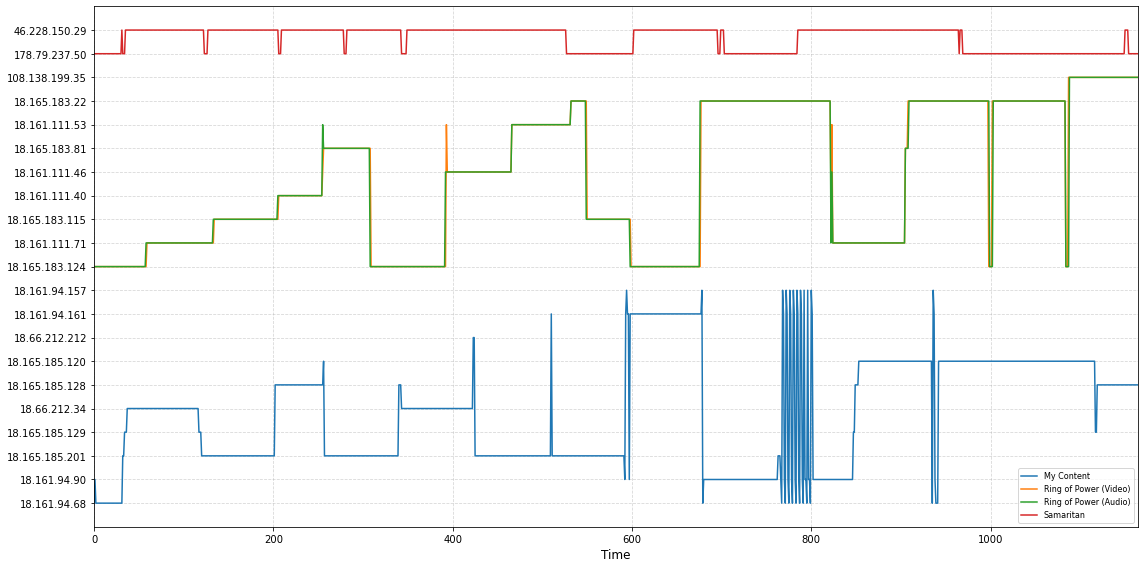

In [13]:
### Server IPs PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
#harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
ax.plot(time[:len(myimage)], myimage, label='My Content')
ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
#ax.plot(time[:len(harlem)], harlem, label='Harlem') # It produces a LOT of IPs!!

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 8)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

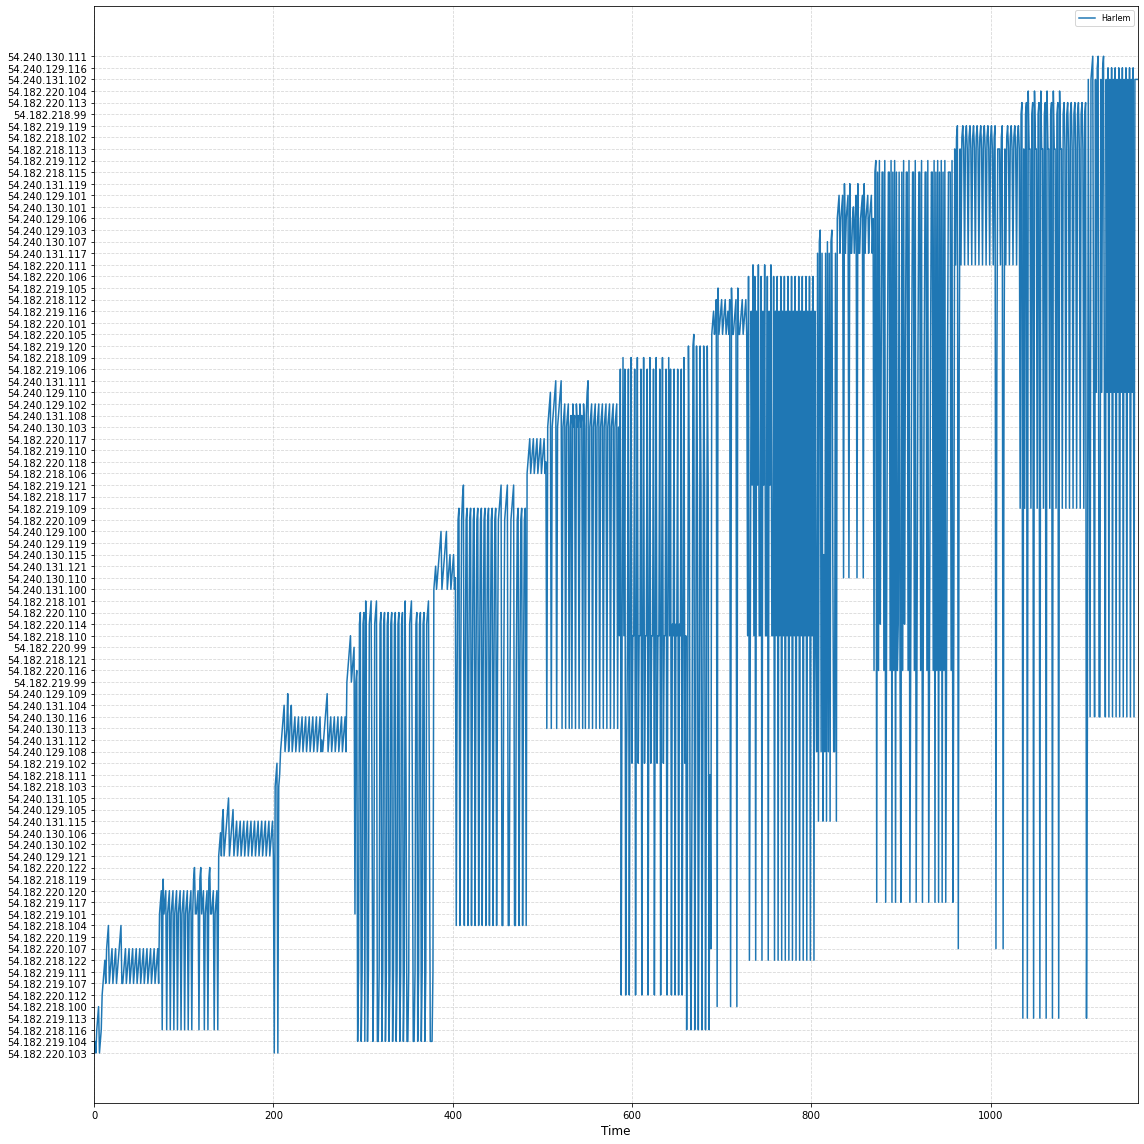

In [14]:
### Server IPs PLOT

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

all_column_values = get_all_column_values("responseIP")

# Define the lists of location values for each website response
myimage = all_column_values["myimage_26-05-2023_02hh_41mm.csv"]
ringsofpower_vid = all_column_values["ringsofpower_vid_26-05-2023_02hh_41mm.csv"]
ringsofpower_aud = all_column_values["ringsofpower_aud_26-05-2023_02hh_41mm.csv"]
samaritan = all_column_values["samaritan_26-05-2023_02hh_41mm.csv"]
harlem = all_column_values["harlem_26-05-2023_02hh_41mm.csv"]

# Define the time series for the x-axis
max_time = max(len(ringsofpower_vid), len(ringsofpower_aud), len(myimage), len(samaritan), len(harlem))
time = range(max_time)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the numerical values for each website response
#ax.plot(time[:len(myimage)], myimage, label='My Content')
#ax.plot(time[:len(ringsofpower_vid)], ringsofpower_vid, label='Ring of Power (Video)')
#ax.plot(time[:len(ringsofpower_aud)], ringsofpower_aud, label='Ring of Power (Audio)')
#ax.plot(time[:len(samaritan)], samaritan, label='Samaritan')
ax.plot(time[:len(harlem)], harlem, label='Harlem') # It produces a LOT of IPs!!

# Set the x-axis and y-axis labels
ax.set_xlabel('Time', fontsize=12)
#ax.set_ylabel('Hops', fontsize=12)

# Set the title of the plot
#ax.set_title('Numerical Value Changes for Website Responses')

# Add a legend with a white background and increased font size
ax.legend(facecolor='white', fontsize=8)

# Adjust the figure size and spacing between subplots
fig.set_size_inches(16, 16)
fig.tight_layout()

# Adjust the limits of the x-axis and y-axis to remove excess space
ax.set_xlim(0, max_time - 1)

# Add gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show() # HARLEM